# Štatistické testovanie hypotéz

Chceme overiť, či má počet valcov motora vplyv na spotrebu.

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing

%matplotlib inline

In [2]:
cars = pd.read_csv('data/auto-mpg.data', delim_whitespace=True, 
                       names = ['mpg', 'cylinders', 'displacement','horsepower',
                                'weight', 'acceleration', 'model_year', 'origin', 'name'],
                        na_values='?')
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [3]:
cars.cylinders.unique()

array([8, 4, 6, 3, 5], dtype=int64)

In [4]:
cars.cylinders.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

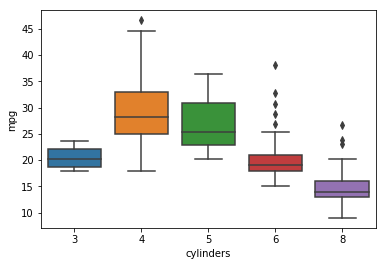

In [5]:
sns.boxplot(x='cylinders', y='mpg', data=cars)

Vidíme, že v datasete máme viacero typov motora (podľa počtu valcov). Už z vizualizácie pomocou boxplotov vidíme, že existuje vzťah medzi počtom valcov a spotrebou (vyjadrenou ako počet míľ, ktoré je auto schopné prejsť na jeden galón paliva, t. j. miles per gallon, `mpg`).

Máme viacero možností, ako otestovať typ tohto vzťahu:

* môžeme sa pozrieť, či je medzi týmito dvomi atribútmi korelácia
* môžeme skúsiť *nafitovať* (napr. lineárny) regresný model
* môžeme otestovať rozdiely medzi priemermi skupín podľa počtu valcov.

My sa pozrieme na tú poslednú možnosť. Otestujme hypotézu, že **rozdiel medzi spotrebou 6 a 8-valcových motorov je signifikantný**.

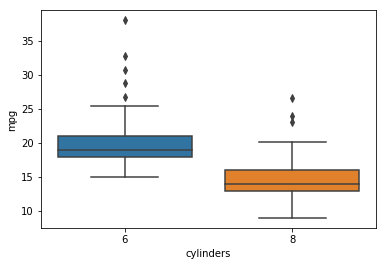

In [6]:
sns.boxplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 6) | (cars.cylinders == 8)])

Nejaký rozdiel tam je, to vidíme aj na základe vizuálneho porovnania. Ak chceme overiť, či je signifikantný, potrebujeme použiť štatistický test.

![tests](img/tests.png)

Máme dve skupiny, vťah medzi nimi je nezávislý (motor má vždy buď 6 alebo 8 valcov). Do úvahy teda pripadá *t-test* alebo *Mann-Whitenyho U test*. Volíme t-test, ak sú splnené jeho predpoklady.

## Overenie predpokladov

### Predpoklad normálnosti rozdelenia

Normálnosť rozdelenia si vieme overiť vizuálne pomocou histogramu, prípadne pomocou tzv. QQ-grafu.

In [7]:
mpg6 = cars.loc[cars.cylinders == 6, 'mpg']

In [8]:
mpg6.describe()

count    84.000000
mean     19.985714
std       3.807322
min      15.000000
25%      18.000000
50%      19.000000
75%      21.000000
max      38.000000
Name: mpg, dtype: float64

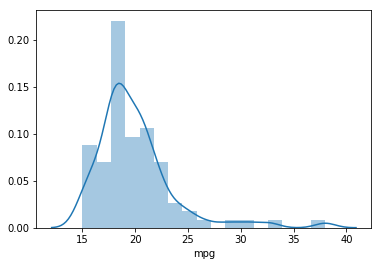

In [9]:
sns.distplot(mpg6)

Vo vzorke sa nachádzajú vychýlené hodnoty. Najjednoduchšou metódou na identifikáciu vychýlených hodnôt (outlierov) je označiť za vychýlenú hodnotu pozorovanie, ktoré sa odlišuje o viac ako 1,5 násobok medzikvartilového rozdelenia od horného, resp. dolného kvartilu.

In [10]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

In [11]:
mpg6_out = identify_outliers(mpg6)
mpg6_out

306    28.8
307    26.8
333    32.7
360    30.7
387    38.0
Name: mpg, dtype: float64

In [12]:
mpg6 = mpg6.drop(mpg6_out.index)

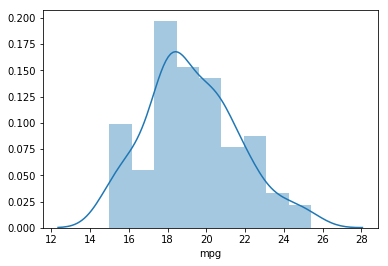

In [13]:
sns.distplot(mpg6)

In [14]:
mpg8 = cars.loc[cars.cylinders == 8, 'mpg']

In [15]:
mpg8.describe()

count    103.000000
mean      14.963107
std        2.836284
min        9.000000
25%       13.000000
50%       14.000000
75%       16.000000
max       26.600000
Name: mpg, dtype: float64

In [16]:
mpg8_out = identify_outliers(mpg8)
mpg8_out

298    23.0
300    23.9
364    26.6
Name: mpg, dtype: float64

In [17]:
mpg8 = mpg8.drop(mpg8_out.index)

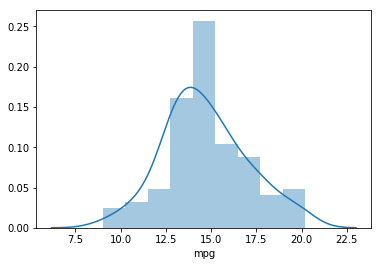

In [18]:
sns.distplot(mpg8)

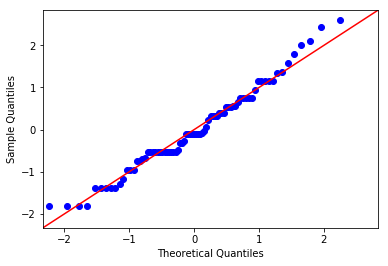

In [19]:
_ = sm.ProbPlot(mpg6, fit=True).qqplot(line='45')

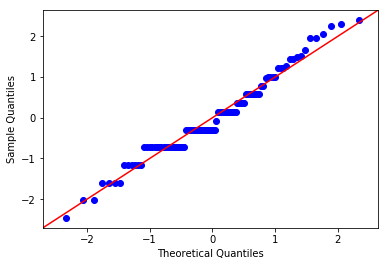

In [20]:
_ = sm.ProbPlot(mpg8, fit=True).qqplot(line='45')

QQ-plot je vizuálna metóda na určenie, či dve dátove sady pochádzajú z rovnakého rozdelenia. Najčastejšie sa porovnáva rozdelenie vzorky s teoretickým normálnym rozdelením. Bod na grafe zobrazuje hodnotu kvantilu v prvom a druhom porovnávanom datasete.

#### Na aké otazky vie QQ-plot odpovedať?

* Pochadzajú dve skupiny pozorovaní z rovnakého rozdelenia?
* Pochádza pozorovaná vzorka z testovaného teoretického rozdelenia (napr. normálneho)?
* Majú rozdelenia podobné vlastnosti asymetrie (skewness) a špicatosti (kurtosis)?

#### Veľmi pekný príspevok o tom, ako interpretovať QQ-plot
https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot

![QQ-plot](img/qq-plot.png)

#### Shapiro-Wilkov test normálnosti

Na overenie normálnosti vieme použiť aj **Shapiro-Wilkov test**, ktorý testuje nulovú hypotézu, že dáta pochádzajú z normálneho rozdelenia. Ak je $p < 0,05$, nulovú hypotézu zamietame a dáta pravdepodobne pochádzajú z iného ako normálneho rozdelenia. Ak je $p > 0,05$, nulovú hypotézu nezamietame, teda na základe dát nemôžeme prehlásiť, že by dáta pochádzali z iného, ako normálneho rozdelenia.

In [21]:
stats.shapiro(mpg6)

(0.9750953912734985, 0.12478790432214737)

In [22]:
stats.shapiro(mpg8)

(0.9733667373657227, 0.04022931680083275)

Funkcia nám vrátila dve hodnoty - hodnotu testovacej štatistiky (v tomto prípade $W$) a $p$-hodnotu. Štatistický test testuje, či je hodnota testovacej štatistiky väčšia ako kritická hodnota. $p$-hodnota predstavuje pravdepodobnosť, že v prípade pravdivosti nulovej hypotézy by bola hodnota testovacej štatistiky rovnaká alebo ešte väčšia.

Vzťah medzi hodnotou testovacej štatistiky, $p$-hodnotou a úrovňou chyby 1. rádu $\alpha$ je dobre znázornená na obrázku nižšie.

![p-value](img/p-value.png)

Zdroj: https://stats.stackexchange.com/questions/124178/why-do-we-compare-p-value-to-significance-level-in-hypothesis-testing-of-mean

Ďalší dobrý zdroj vysvetľujúci vzťah medzi $p$-hodnotou a úrovňou chyby 1. rádu $\alpha$: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-hypothesis-tests-significance-levels-alpha-and-p-values-in-statistics

Na základe výsledkov testu sa zdá, že vzorka aút so 6-valcovými motormi pochádza z normálneho rozdelenia, vzorka s 8-valcovými motormi nie. Mali by sme teda použiť neparametrickú verziu t-testu, t. j. **Mann-Whitneyho U-test** (hoci t-test je nad istý počet vzoriek relatívne robustný na mierne odchýlky od predpokladu normálnosti).

### Podobnosť variancie

Druhým predpokladom použitia t-testu je rovnosť variancií (hoci existuje variant t-testu, ktorý vie pracovať aj s dátami s nerovnakou varianciou). Hoci sme neoverili predpoklad normálnosti rozdelení, pozrime sa na ich variancie. 

Na otestovanie podobnosti variancií sa používa **Levenov test**. Testuje nulovú hypotézu, že všetky vstupné vzorky pochádzajú z rozdelení s rovnakými varianciami. Ak nulovú hypotézu nezamietame ($p > 0,05$), znamená to, že na základe dát nemôžeme prehlásiť, že by vzorky pochádzali z distribúcií s rôznymi varianciami.

In [23]:
stats.levene(mpg6, mpg8)

LeveneResult(statistic=0.044821392421680255, pvalue=0.8325763705509353)

Na základe výsledku testu sa zdá, že vzorky pochádzajú z rozdelení s rovnakou varianciou.

### Studentov t-test vs. Mann-Whiteneyho U-test

Keďže neboli splnené predpoklady t-testu, mali by sme použiť jeho neparametrickú verziu. Ak by boli splnené, použili by sme funkciu `scipy.stats.ttest_ind`.

In [24]:
stats.mannwhitneyu(mpg6, mpg8)

MannwhitneyuResult(statistic=668.0, pvalue=6.202693470007155e-22)

Keďže $p < 0,001$, pravdepodobnosť chyby 1. rádu (že nulová hypotéza je pravdivá, a my ju zamietame) je menej ako 1 promile. Rozdiel v spotrebe medzi 6 a 8-valcovými motormi je štatisticky signifikantný.

Môžeme si vizualizovať rozdiel medzi dvomi priemermi - často sa zobrazujú pomocou stĺpcových diagramov spolu s *intervalmi spoľahlivosti*, ktoré nám hovoria, že s N% pravdepodobnosťou (najčastejšie sa používa 95) sa skutočná hodnota priemeru bude nachádzať niekde v danom intervale.

In [25]:
sms.DescrStatsW(mpg6).tconfint_mean()

(18.73322498793141, 19.793357290549597)

In [26]:
sms.DescrStatsW(mpg8).tconfint_mean()

(14.21682605452332, 15.137173945476686)

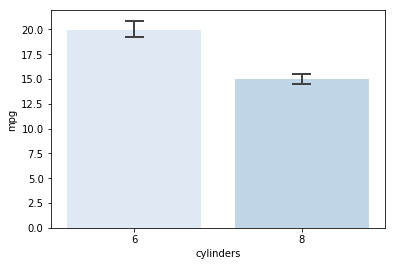

In [27]:
sns.barplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 8) | (cars.cylinders == 6)], 
            capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"))

## Príklady na precvičenie

a. Analogicky k príkladu vyššie overte, či je rozdiel medzi spotrebou 4 a 6-valcových motorov signifikantný.

b. Analogicky k príkladu vyššie overte, či je rozdiel medzi spotrebou 4 a 5-valcových motorov signifikantný.

Treba si dať pozor pri opakovanom párovom testovaní. S každým ďalším testom rastie pravdepodobnosť 1. rádu. Treba v takom prípade použiť korekciu pre opätovné testovanie, napr. *Bonferroniho korekciu*, kedy sa $p$-hodnota porovnáva voči hodnote $\alpha / m$, kde $\alpha$ je prípustná hodnota pravdepodobnosti chyby 1. rádu a $m$ je počet testovaných hypotéz (párových testov).

Ešte lepší postup je použiť test, ktorý umožňuje otestovať viacero skupín naraz. Zovšeobecnením t-testu pre viacero skupín je **ANOVA (Analysis of variance)**.

### Úloha 1.A

In [28]:
mpg4 = cars.loc[cars.cylinders == 4, 'mpg']

In [29]:
mpg4.describe()

count    204.000000
mean      29.286765
std        5.710156
min       18.000000
25%       25.000000
50%       28.250000
75%       33.000000
max       46.600000
Name: mpg, dtype: float64

In [30]:
mpg4_out = identify_outliers(mpg4)
mpg4_out

322    46.6
Name: mpg, dtype: float64

In [31]:
mpg4 = mpg4.drop(mpg4_out.index)

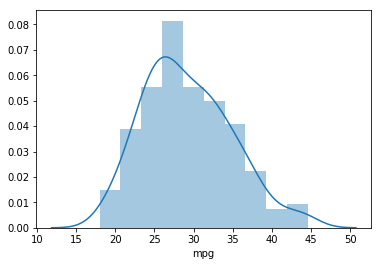

In [32]:
sns.distplot(mpg4)

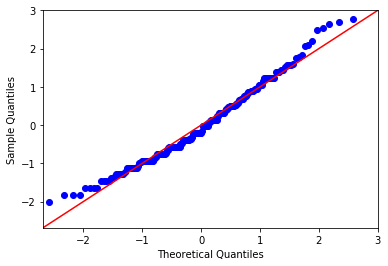

In [33]:
_ = sm.ProbPlot(mpg4, fit=True).qqplot(line='45')

In [34]:
stats.shapiro(mpg4)

(0.9778177738189697, 0.0026729200035333633)

Na základe výsledkov Shapiro-Wilkovho testu zamietame nulovú hypotézu, že by vzorka `mpg4` pochádzala z normálneho rozdelenia.

In [35]:
stats.levene(mpg4, mpg6)

LeveneResult(statistic=44.69812686636985, pvalue=1.2426744330585115e-10)

Taktiež nie je splnený predpoklad rovnakej variancie. Použijeme neparametrickú verziu t-testu - Mann-Whitneyho U-test.

In [36]:
stats.mannwhitneyu(mpg4, mpg6)

MannwhitneyuResult(statistic=563.0, pvalue=3.819576222827491e-34)

Rozdiel je štatisticky signifikantný (toto je už druhý test - spolu je 10 rôznych dvojíc typov motorov, ktoré by sme mohli navzájom testovať; aby sme udržali pravedpodobnosť chyby 1. rádu, mala by p-hodonota byť menšia ako 0,05/10, čo v tomto prípade platí). Môžeme si rozdiel vizualizovať pomocou stĺpcového grafu s intervalmi spoľahlivosti.

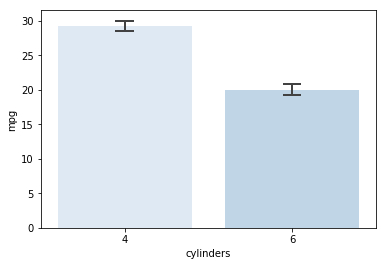

In [37]:
sns.barplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 4) | (cars.cylinders == 6)], 
            capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"))

### Úloha 1.B

In [38]:
mpg5 = cars.loc[cars.cylinders == 5, 'mpg']

In [39]:
mpg5.describe()

count     3.000000
mean     27.366667
std       8.228204
min      20.300000
25%      22.850000
50%      25.400000
75%      30.900000
max      36.400000
Name: mpg, dtype: float64

Vidíme, že v datasete sú len 3 autá s 5 valcovými motormi, čo je veľmi malá vzorka. Pri takej vzorke treba zvážiť, či má vôbec zmysel testovať nejakú štatistickú významnosť (je veľmi ťažké vylúčiť, že pozorovaný rozdiel je daný len náhodou). Pre kompletnosť však test napriek tomu vykonáme. 

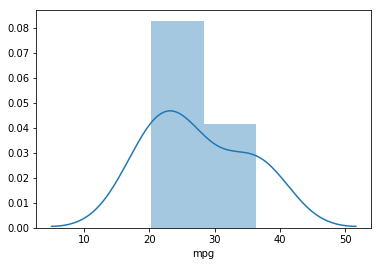

In [40]:
sns.distplot(mpg5)

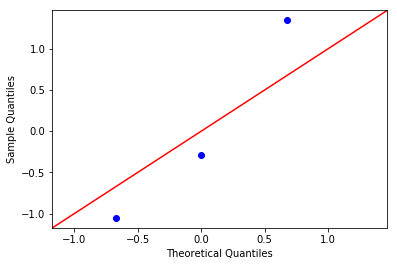

In [41]:
_ = sm.ProbPlot(mpg5, fit=True).qqplot(line='45')

In [42]:
stats.shapiro(mpg5)

(0.957153856754303, 0.6017923951148987)

In [43]:
stats.levene(mpg4, mpg5)

LeveneResult(statistic=0.16890066750754787, pvalue=0.6815220524141329)

Hoci pri 5-valcových motoroch nevieme vylúčiť predpoklad normálneho rozdelenia, pri 4-valcových splnený nebol, takže opäť použijeme neparametrickú verziu t-testu - Mann-Whitneyho U-test.

In [44]:
stats.mannwhitneyu(mpg4, mpg5)

MannwhitneyuResult(statistic=246.0, pvalue=0.2856390517810905)

Rozdiel nie je štatisticky signifikantný Môžeme si ho vizualizovať pomocou stĺpcového grafu s intervalmi spoľahlivosti.

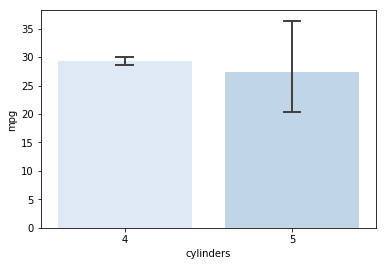

In [45]:
sns.barplot(x='cylinders', y='mpg', data=cars[(cars.cylinders == 4) | (cars.cylinders == 5)], 
            capsize=0.1, errwidth=2, palette=sns.color_palette("Blues"))

Vidíme, že podľa očakávaní je interval spoľahlivosti pri 5-valcových motoroch veľmi široký (inak povedané, máme len veľmi hrubý odhad, kde sa nachádza skutočná hodnota priemeru). To malo za následok aj nezamietnutie nulovej hypotézy, hoci v dátach zdanlivo rozdiel je. 